In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import altair as alt 

In [9]:
train = pd.read_csv('data/sales_train.csv.gz')
items = pd.read_csv('data/items.csv')
categories = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')

test = pd.read_csv('data/test.csv.gz')
submission = pd.read_csv('data/sample_submission.csv.gz')

In [10]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [11]:
train.shape

(2935849, 6)

In [12]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [13]:
test.shape

(214200, 3)

In [14]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


As we can see, the test set is different in size and structure when compared to the training set. We have the features 'shop_id' and 'item_id' in the test set, which are present in the trianing set as well. Each observation in the test set has an ID associated with it. If we look at our submission file, we need to submit the monthly count (item_cnt_month) for that particular ID. This means we need to predict a number for the monthly sale quantity of a particular item at a particular shop.

Let's look at the distribution of the training and test set to understand our dataset better and check for overlap, or lack thereof.

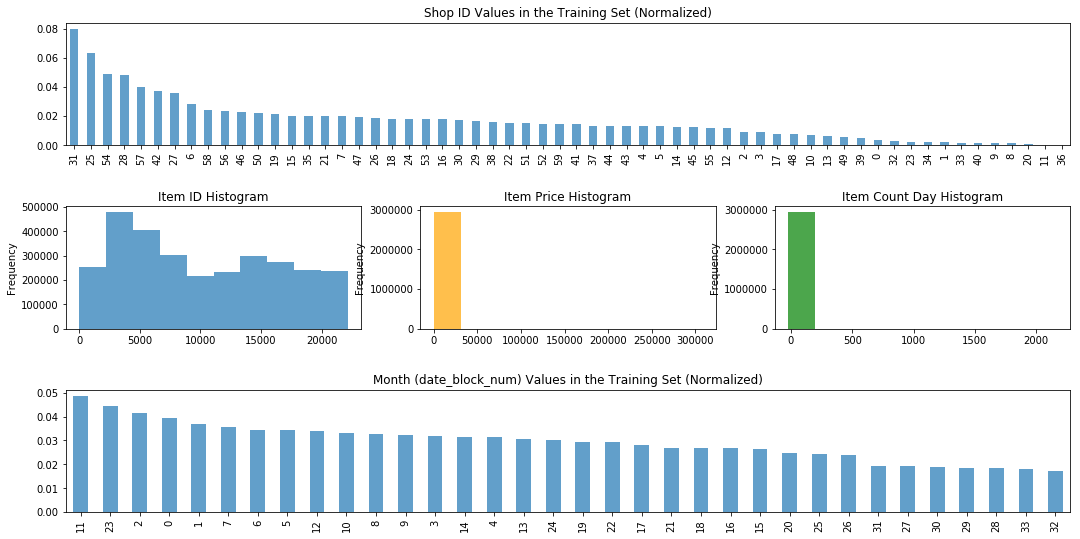

In [43]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
train['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
train['item_price'].plot(kind='hist', alpha=0.7, color='orange')
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
train['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3)
train['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')
plt.show()

The above graphs are a nice way to look at the raw distribtion of the test dataset. Here are some observations:

1. We have 60 'shop_id's but there is an uneven distribtution of these in the dataset. Four (<7%) of these shops make up ~25 percent of this dataset. These are shops (31, 25, 54, 28).


2. The Item IDs seem to have variations in frequency. We can't attribute a reason to this yet but we can inspect this further. Certain cateogeries are bound to sell better and maybe items under the same category are closer to each other as far as their ID distributions are concerned


3. From the vast empty spaces in the histograms of 'item_price' and 'item_cnt_day', we can infer that there are outliers in their distribution. **Let's write some simple code below to put a value to these outliers.**


4. Plotting the individual months from January 2013 to October 2015, it is interesting to see that the block month 12, corresponding to December 2013, had the highest number of sales. Month 23, which corresponds to December 2014, had the second highest number of sales. Shortly, we will use some better graphs to observe the monthly sale trends.

In [44]:
train['item_id'].value_counts(ascending=False)[:5]

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
Name: item_id, dtype: int64

In [45]:
train['item_cnt_day'].sort_values(ascending=False)[:5]

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
Name: item_cnt_day, dtype: float64

In [46]:
train['item_price'].sort_values(ascending=False)[:5]

1163158    307980.0
885138      59200.0
1488135     50999.0
2327159     49782.0
2910156     42990.0
Name: item_price, dtype: float64

Having a look at the item id 20949 that has been sold the most number of times, it is a plastic bag!

In [49]:
items.loc[items['item_id']==20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [54]:
categories.loc[categories['item_category_id']==71]

,item_category_name,item_category_id
71,"Подарки - Сумки, Альбомы, Коврики д/мыши",71


And just to satisfy my curiosity bowels, there is only one itemm under item category 71

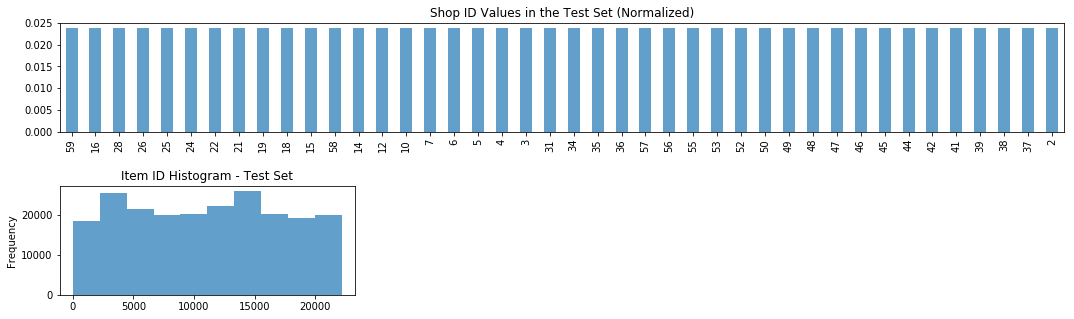

In [56]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
test['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Shop ID Values in the Test Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
test['item_id'].plot(kind='hist', alpha=0.7)
plt.title('Item ID Histogram - Test Set')
plt.show()

1. The Shop Id's are evenly spread out, unlike the training set. The font size of labels quickly tells me that there are certain Shop Id's missing in the test set as the bars in the training set 'shop_id' plot were more tightly packed.


2. While item id's in the histogram are binned, the spikes are less in the test set. The test set is much smaller in shape than the training set, and naturally, the frequency values are significantly lower. It is tough to be draw more insights from this histogram.

It seems there might be some values of shop_id and item_id completely missing in the test set. Let's have a closer look and put some numbers or percentages to these missing values.